<a href="https://colab.research.google.com/github/peremartra/Large-Language-Model-Notebooks-Course/blob/main/6-PRUNING/6_7_benchmark_inference_pruned_vs_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div>
    <h1>Large Language Models Projects</a></h1>
    <h3>Apply and Implement Strategies for Large Language Models</h3>
    <h2>Inference Efficiency Benchmark: Base vs. Pruned Model</h2>
    <h3>Evaluate speed and efficiency gains from structured pruning.</h3>
</div>

by [Pere Martra](https://www.linkedin.com/in/pere-martra/)
_______
Models: meta-llama/Llama-3.2-1B vs oopere/pruned40-llama-3.2-1B

Colab Environment: GPU T4.

Keys:
* Inference
* BenchMarks
* PowerConsumption
* CodeCarbon

_______
<table style="border: none; background: none;">
  <tr style="border: none;">
    <td style="border: none; vertical-align: middle; width: 120px;">
      <a href="https://hubs.la/Q040tvsK0">
        <img src="https://raw.githubusercontent.com/peremartra/Rearchitecting-LLMs/main/Images/cover.png" width="110" style="border-radius: 4px;">
      </a>
    </td>
    <td style="border: none; vertical-align: middle;">
      <h2 style="margin: 0;">Ready to Master LLM Pruning?</h2>
      <p style="margin: 5px 0;">Take your skills to the next level with my new book <strong>"Rearchitecting LLMs"</strong> (Manning Publications).</p>
      <p style="margin: 5px 0;"> <strong>Special Offer:</strong> Get the MEAP at <strong>50% off</strong> using code <strong>MLMartra</strong> (valid until Feb 26th).</p>
      <p>
        <a href="https://hubs.la/Q040tvsK0"><strong> Upgrade your knowledge and check the MEAP here</strong></a>
      </p>
    </td>
  </tr>
</table>

______
# INTRODUCTION
This notebook benchmarks the **inference performance** of two Hugging Face models: a base model (`meta-llama/Llama-3.2-1B`) and its **pruned** version (`oopere/pruned40-llama-3.2-1B`).

We evaluate and compare them in terms of:
- **Latency** (including Time To First Token and token-level percentiles)
- **Throughput** across different batch sizes
- **GPU memory usage** for increasing context lengths
- **Energy consumption and emissions**, using CodeCarbon

Although this is an evaluation notebook, it is included in the **Pruning and Optimization** section because it directly analyzes the **impact of pruning techniques** on efficiency and environmental cost.

## 1. Configurations & Imports.

In [ ]:
!pip install -q codecarbon

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 576.3/576.3 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.0/278.0 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 57.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.5/92.5 kB 7.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-genai 1.10.0 requires httpx<1.0.0,>=0.28.1, but you have httpx 0.27.2 which is incompatible.


In [ ]:
# Initial Configuration
import os
import time
import json
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import psutil
import matplotlib.pyplot as plt
import numpy as np

# Try importing CodeCarbon to track emissions
try:
    from codecarbon import EmissionsTracker
    codecarbon_available = True
except ImportError:
    print("Warning: CodeCarbon is not installed. Environmental tracking will be skipped.")
    codecarbon_available = False

# Try importing NVIDIA Management Library to retrieve GPU metrics
try:
    import pynvml
    pynvml.nvmlInit()
    gpu_available = True
except ImportError:
    print("Warning: pynvml is not installed. GPU metrics may be limited.")
    gpu_available = False

# Detect devices: cuda > mps > cpu
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"


In [ ]:
# Model loading parameters
USE_QUANTIZED = False  # Set to True to load in 8-bit mode

In [ ]:
codecarbon_available

True

## 2. Model and prompt loading functions
In this section, we define utility functions to:

* Load a model and its tokenizer from the Hugging Face Hub
* Optionally enable 8-bit quantization for reduced memory usage
* Load input prompts from either .json or .jsonl files
* Provide a set of default prompts for quick testing

These functions are designed to keep the benchmarking code clean, modular, and easy to adapt to different models and input formats.

In [ ]:
# Function to load the model and tokenizer
def load_model_and_tokenizer(model_id, use_quantized, device):
    """Loads the model and tokenizer from the Hugging Face Hub."""
    load_kwargs = {"torch_dtype": torch.float16} if device != "cpu" else {}
    if use_quantized:
        load_kwargs["load_in_8bit"] = True
    tokenizer = AutoTokenizer.from_pretrained(model_id)
    if tokenizer.pad_token_id is None:
      tokenizer.pad_token_id = tokenizer.eos_token_id
    model = AutoModelForCausalLM.from_pretrained(model_id, **load_kwargs).to(device)
    model.eval()
    return model, tokenizer

# Function to load prompts from a JSON or JSONL file
def load_prompts_from_file(file_path):
    """Loads prompts from an external file (.json or .jsonl)."""
    prompts = []
    if file_path.endswith(".json"):
        with open(file_path, "r", encoding="utf-8") as f:
            prompts = json.load(f)
    elif file_path.endswith(".jsonl"):
        with open(file_path, "r", encoding="utf-8") as f:
            prompts = [json.loads(line) for line in f]
    else:
        raise ValueError("Unsupported file format. Please use .json or .jsonl")
    return prompts

# Lista de prompts por defecto
example_prompts = [
    "Hello, how are you?",
    "Write a poem about spring.",
    "Summarize the plot of 'One Hundred Years of Solitude'.",
    "Give three tips for maintaining a healthy lifestyle.",
    "Explain the theory of relativity in simple terms."
]

## 3. Benchmarking functions
This section defines all the necessary functions to evaluate the model's performance during inference. These functions allow you to measure several key aspects:

* Latency: average time per token, TTFT (Time To First Token), and percentiles.
* Throughput: tokens generated per second depending on batch size.
* Resource usage: GPU and CPU utilization during generation.
* Context scaling: how latency and memory usage change as prompt length increases.

Energy consumption: total usage, estimated emissions, and per-token metrics (if CodeCarbon is available).

These tools enable comparison of models in terms of computational efficiency and sustainability.

In [ ]:
# Latency Benchmark
def benchmark_latency(model, tokenizer, device, prompts):
    """
    Measures latency: average time per token, TTFT, and percentiles.
    """
    import numpy as np
    tiempos_por_token = []
    ttft_list = []
    for prompt in prompts:
        batch = tokenizer(prompt, return_tensors="pt", padding=True).to(device)
        start_time = time.time()
        with torch.no_grad():
            model.generate(
                input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"],
                max_new_tokens=50,
                pad_token_id=tokenizer.pad_token_id
            )
        end_time = time.time()
        total = end_time - start_time
        tiempos_por_token.extend([total/50] * 50)
        ttft_list.append(total)
    p50, p90, p99 = np.percentile(tiempos_por_token, [50, 90, 99])
    return {
        "mean_token_time": float(np.mean(tiempos_por_token)),
        "ttft_mean": float(np.mean(ttft_list)),
        "p50": float(p50),
        "p90": float(p90),
        "p99": float(p99)
    }

In [ ]:
# Throughput benchmark for different batch sizes
def benchmark_throughput(model, tokenizer, device, prompts, batch_sizes=[1,4,8,16,32]):
    import numpy as np
    results = {}
    handle = None
    if gpu_available and device=="cuda":
        handle = pynvml.nvmlDeviceGetHandleByIndex(0)

    for bs in batch_sizes:
        batch_prompts = prompts[:bs]
        batch = tokenizer(batch_prompts, return_tensors="pt", padding=True, truncation=True).to(device)

        # Measure peak memory usage
        if device=="cuda":
            torch.cuda.reset_peak_memory_stats()

        # Synchronize and measure real time
        if device=="cuda":
            torch.cuda.synchronize()
        start = time.time()

        with torch.no_grad():
            model.generate(
                input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"],
                max_new_tokens=50,
                pad_token_id=tokenizer.pad_token_id
            )

        if device=="cuda":
            torch.cuda.synchronize()
        end = time.time()

        # Collect metrics
        tokens = bs * 50
        peak_mem = (torch.cuda.max_memory_allocated(device) / 1024**2) if device=="cuda" else None
        gpu_util = pynvml.nvmlDeviceGetUtilizationRates(handle).gpu if handle else None
        results[f"batch_{bs}"] = {
            "tokens_per_sec": tokens / (end - start),
            "peak_mem_mb": peak_mem,
            "gpu_util_pct": gpu_util
        }

    return results

In [ ]:
# Context scaling benchmark
def benchmark_context_scaling(model, tokenizer, device, context_lengths=[512,1024,2048,4096]):
    """Evaluates latency and throughput for different context lengths."""
    results = {}
    base_prompt = "word " * max(context_lengths)
    for length in context_lengths:
        inputs = tokenizer(base_prompt, return_tensors="pt", max_length=length, truncation=True).to(device)
        start = time.time()
        with torch.no_grad():
            model.generate(**inputs, max_new_tokens=10)
        end = time.time()
        dur = end - start
        results[f"context_{length}"] = {
            "latency": dur,
            "throughput": 10 / dur
        }
    return results

In [ ]:
def benchmark_memory_context_scaling(model, tokenizer, device, context_lengths=[512,1024,2048,4096]):
    """
    For each length in context_lengths:
      Generate a sufficiently long prompt

      Measure GPU peak memory (in MB)
      Returns a dict: {"512": peak_mb, "1024": peak_mb, …}
    """
    results = {}
    base = "palabra " * max(context_lengths)
    for L in context_lengths:
        # Prepara el batch con truncation
        inputs = tokenizer(base, return_tensors="pt", max_length=L, truncation=True).to(device)
        if device=="cuda":
            # Resetea contadores
            torch.cuda.reset_peak_memory_stats()
        with torch.no_grad():
            model.generate(**inputs, max_new_tokens=1)
        if device=="cuda":
            peak = torch.cuda.max_memory_allocated(device) / 1024**2
        else:
            peak = None
        results[L] = peak
    return results

In [ ]:
# Resources Benchmark (GPU y CPU)
def benchmark_resource_usage(model, tokenizer, device, prompts):
    """Measures GPU and CPU utilization during inference."""
    data = {}
    for p in prompts:
        inputs = tokenizer(p, return_tensors="pt").to(device)
        if gpu_available:
            handle = pynvml.nvmlDeviceGetHandleByIndex(0)
            mem = pynvml.nvmlDeviceGetMemoryInfo(handle)
            util = pynvml.nvmlDeviceGetUtilizationRates(handle)
            power = pynvml.nvmlDeviceGetPowerUsage(handle)/1000.0
        else:
            mem = util = power = None
        cpu = psutil.cpu_percent(interval=None)
        data[p] = {
            "gpu_mem_used": mem.used if mem else None,
            "gpu_util": util.gpu if util else None,
            "gpu_power_w": power,
            "cpu_util": cpu
        }
    return data

## 4. Results visualization
This section includes functions to visually represent the results obtained during benchmarking. These visualizations allow for a more intuitive and comparative analysis of the performance of the evaluated models.

The following aspects are covered:

* Latency: comparison of TTFT and per-token times with percentiles.
* Throughput: tokens per second as a function of batch size.
* Memory usage: GPU consumption as context length increases.
* Environmental impact: energy consumption, average power, and emissions per token.

These charts help identify bottlenecks, efficiency advantages, and the real impact of techniques like structured pruning.

In [ ]:
# Visualization functions.
def plot_latency(latency, latency2=None):
    """
    Draw two bar charts side by side:
      - Left: only TTFT (ttft_mean)
      - Right: mean_token_time and percentiles p50, p90, p99
    If a second result (latency2) is provided, plot both sets in different colors for comparison.
    """
    import numpy as np
    import matplotlib.pyplot as plt

    # Figure setup and bar width configuration
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    width = 0.35

    # --- Chart 1: TTFT (ttft_mean) ---
    métricas1 = ["ttft_mean"]
    x1 = np.arange(len(métricas1))
    # Result 1
    ax1.bar(x1 - width/2, [latency["ttft_mean"]], width, label="Result 1", color="tab:blue")
    # Result 2 (if exists)
    if latency2 is not None:
        ax1.bar(x1 + width/2, [latency2["ttft_mean"]], width, label="Result 2", color="tab:orange")
    ax1.set_title("Time to First Token (TTFT)")
    ax1.set_ylabel("Seconds")
    ax1.set_xticks(x1)
    ax1.set_xticklabels(métricas1)
    ax1.tick_params(axis="x", rotation=0)
    if latency2 is not None:
        ax1.legend()

    # --- Chart 2: Mean token time + percentiles ---
    métricas2 = ["mean_token_time", "p50", "p90", "p99"]
    x2 = np.arange(len(métricas2))
    # Result 1
    ax2.bar(x2 - width/2, [latency[m] for m in métricas2], width, label="Result 1", color="tab:blue")
    # Result 2 (if exists)
    if latency2 is not None:
        ax2.bar(x2 + width/2, [latency2[m] for m in métricas2], width, label="Result 2", color="tab:orange")
    ax2.set_title("Mean Token Time and Percentiles")
    ax2.set_ylabel("Seconds")
    ax2.set_xticks(x2)
    ax2.set_xticklabels(métricas2)
    ax2.tick_params(axis="x", rotation=0)
    if latency2 is not None:
        ax2.legend()

    plt.tight_layout()
    plt.show()


def plot_throughput(results1, results2=None):
    """
    Compares throughput from one or two results:
      - Throughput (tokens/s) as bars.
      - Use colors tab:blue and tab:orange (same as plot_latency).
      - Annotate average prompt length for each model.
    """
    # Throughput data
    tp1 = results1["throughput_metrics"]
    batches = sorted(int(k.split('_')[1]) for k in tp1.keys())
    x = np.arange(len(batches))
    width = 0.35

    tokens1 = [tp1[f"batch_{b}"]["tokens_per_sec"] for b in batches]

    if results2:
        tp2 = results2["throughput_metrics"]
        tokens2 = [tp2[f"batch_{b}"]["tokens_per_sec"] for b in batches]

    # Plot
    plt.figure(figsize=(8, 4))
    plt.bar(x - width/2, tokens1, width, label="Model 1", color="tab:blue")
    if results2:
        plt.bar(x + width/2, tokens2, width, label="Model 2", color="tab:orange")
    plt.xlabel("Batch size")
    plt.ylabel("Tokens/s")
    plt.title("Throughput vs Batch size")
    plt.xticks(x, batches)

    # Average prompt length annotation
    notes = []
    m1 = results1.get("prompt_stats", {}).get("mean_length")
    if m1:
        notes.append(f"M1 long. average prompts: {m1:.1f}")
    if results2:
        m2 = results2.get("prompt_stats", {}).get("mean_length")
        if m2:
            notes.append(f"M2 long. average prompts: {m2:.1f}")
    if notes:
        plt.text(
            0.95, 0.95,
            "\n".join(notes),
            transform=plt.gca().transAxes,
            ha="right", va="top",
            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7)
        )

    if results2:
        plt.legend()
    plt.tight_layout()
    plt.show()

def plot_memory_scaling(results1, results2=None):
    """
    Compares peak memory usage as a function of context length
    for one or two sets of results.
      Parameters:
        results1: a 'results' dictionary with 'memory_context_metrics'
        results2: (optional) second 'results' dictionary
    """
    # Extract memory metrics by context length
    mem1 = results1.get("memory_context_metrics", {})
    if not mem1:
        print("No memory_context_metrics data found in results1.")
        return
    # Order context
    ctx1, vals1 = zip(*sorted(mem1.items()))

    # Get figure ready
    plt.figure(figsize=(6,4))
    plt.plot(ctx1, vals1, marker="o", linestyle="-", label="Modelo 1", color="tab:blue")

    # process second results
    if results2:
        mem2 = results2.get("memory_context_metrics", {})
        if mem2:
            ctx2, vals2 = zip(*sorted(mem2.items()))
            # Verificar que ctx2 coincide con ctx1 para comparar
            if list(ctx2) != list(ctx1):
                print("Warning: The context lengths in results2 differ. They will be plotted separately.")
            plt.plot(ctx2, vals2, marker="x", linestyle="--", label="Modelo 2", color="tab:orange")

    # Labels
    plt.title("Memory vs Context Length")
    plt.xlabel("Context (tokens)")
    plt.ylabel("Memory peak (MB)")
    plt.xticks(ctx1)
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_environmental_comparison(results1, results2):
    """
      Compares environmental metrics in three separate subplots:
      - Average power (W)
      - Energy per token (kWh)
      - Emissions per token (kg CO₂)
    """
    ei1 = results1["environmental_impact"]
    ei2 = results2["environmental_impact"]

    metrics = [
        ("avg_power_w", "Average power (W)"),
        ("energy_per_token_kwh", "Energy/token (kWh)"),
        ("emissions_per_token_kg", "Emissions/token (kg CO₂)")
    ]

    fig, axes = plt.subplots(1, 3, figsize=(14, 4))

    for ax, (key, label) in zip(axes, metrics):
        # Extraer valores
        v1 = ei1.get(key, 0)
        v2 = ei2.get(key, 0)

        # Dibujar barras
        ax.bar(["Model 1", "Model 2"], [v1, v2], color=["tab:blue", "tab:orange"])
        ax.set_title(label)
        ax.set_ylabel(label)

        # Rotar y alinear etiquetas X
        ax.tick_params(axis="x", labelrotation=45)
        # Alineación horizontal de cada etiqueta
        for lbl in ax.get_xticklabels():
            lbl.set_ha("right")

        # Anotar valor encima de las barras
        for i, v in enumerate([v1, v2]):
            texto = f"{v:.2e}" if abs(v) < 1e-2 else f"{v:.2f}"
            ax.text(i, v * 1.01, texto, ha="center", va="bottom")

    plt.suptitle("Environmental comparison per token / average power")
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

## 5. Full execution and result saving

This section brings together all the previous functions into a single workflow that:

- Runs the various performance and environmental impact benchmarks.  
- Collects and organizes the metrics into a single structured dictionary.  
- Computes additional indicators such as energy per token and average power.  
- Saves the results in a benchmark_results.json file for later analysis.  

This block allows automated model evaluation with a single line of code, making it easier to systematically compare different versions or optimized variants.

In [ ]:
def run_all_benchmarks(model, tokenizer, device, prompts):
    results = {}
    # Prompt length statistics
    token_lengths = [len(tokenizer.encode(p)) for p in prompts]
    results["prompt_stats"] = {
        "lengths": token_lengths,
        "mean_length": sum(token_lengths) / len(token_lengths)
    }
    # 1. Prepare environmental tracking
    env_start = time.time()
    if codecarbon_available:
        try:
            # Some versions need 2-letter country codes some others 3-letter code.
            tracker = EmissionsTracker(country_iso_code="ESP")
        except TypeError:
            print("Warning: 'country_iso_code' incorrect. Using default configuration.")
            tracker = EmissionsTracker()
        tracker.start()

    # 2. model info.
    results["model_info"] = {
        "base_model": model.config._name_or_path,
        "quantized": USE_QUANTIZED,
        "device": device,
        "torch_version": torch.__version__,
        "cuda_available": torch.cuda.is_available(),
        "timestamp": time.strftime("%Y-%m-%dT%H:%M:%S", time.localtime())
    }

    # 3. Run benchmarks
    results["latency_metrics"]    = benchmark_latency(model, tokenizer, device, prompts)
    results["throughput_metrics"] = benchmark_throughput(model, tokenizer, device, prompts)
    results["context_metrics"]    = benchmark_context_scaling(model, tokenizer, device)
    results["resource_metrics"]   = benchmark_resource_usage(model, tokenizer, device, prompts)
    results["memory_context_metrics"] = benchmark_memory_context_scaling(model, tokenizer, device)

    # 4. Stop and collect environmental impact data
    if codecarbon_available:
        # tracker.stop() Returns the energy consumed in kWh (float) :contentReference[oaicite:3]{index=3}
        energy_kwh = tracker.stop()
        # tracker.flush() Writes to disk/API and returns emissions in kg of CO₂ :contentReference[oaicite:4]{index=4}
        emissions_kg = tracker.flush()
        duration = time.time() - env_start

        results["environmental_impact"] = {
            "energy_consumed_kwh": energy_kwh,
            "emissions_kg": emissions_kg,
            "country": getattr(tracker, "country_iso_code", "N/A"),
            "duration_seconds": duration
        }

        ei = results["environmental_impact"]
        energy_kwh   = ei["energy_consumed_kwh"]
        emissions_kg = ei["emissions_kg"]
        duration_s   = ei["duration_seconds"]

        # 1) Average power (W)
        #   1 kWh = 1000 Wh, y power = Wh / (s/3600)
        avg_power_w = (energy_kwh * 1000) / (duration_s / 3600)

        # 2) Throughput total tokens generated(sum bs*50)
        batch_sizes = [int(k.split("_")[1]) for k in results["throughput_metrics"].keys()]
        total_tokens = sum(batch_sizes) * 50

        # 3) Consumption per token (kWh/token) and emissions per token (kg/token)
        energy_per_token   = energy_kwh / total_tokens
        emissions_per_token = emissions_kg / total_tokens

        # Guardar en el mismo bloque de environmental_impact
        ei.update({
            "avg_power_w": avg_power_w,
            "energy_per_token_kwh": energy_per_token,
            "emissions_per_token_kg": emissions_per_token
        })


    # 5. Guardar a JSON
    with open("benchmark_results.json", "w", encoding="utf-8") as f:
        json.dump(results, f, indent=4, ensure_ascii=False)
    print("Results stored at benchmark_results.json")
    return results


In [ ]:
# Load models and ejecution
model, tokenizer = load_model_and_tokenizer("meta-llama/Llama-3.2-1B", USE_QUANTIZED, device)
model2, tokenizer = load_model_and_tokenizer("oopere/pruned40-llama-3.2-1B", USE_QUANTIZED, device)
prompts = example_prompts


In [ ]:
results = run_all_benchmarks(model, tokenizer, device, prompts)

[codecarbon WARNING @ 09:08:42] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 09:08:42] [setup] RAM Tracking...
[codecarbon INFO @ 09:08:42] [setup] CPU Tracking...


[codecarbon WARNING @ 09:08:43] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 09:08:43] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 09:08:43] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.30GHz
[codecarbon WARNING @ 09:08:43] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 09:08:43] [setup] GPU Tracking...
[codecarbon INFO @ 09:08:43] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 09:08:43] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: pynvml
            
[codecarbon INFO @ 09:08:43] >>> Tracker's metadata:
[codecarbon INFO @ 09:08:43]   Platform sys

Results stored at benchmark_results.json


In [ ]:
results

{'prompt_stats': {'lengths': [7, 7, 15, 10, 12], 'mean_length': 10.2},
 'model_info': {'base_model': 'meta-llama/Llama-3.2-1B',
  'quantized': False,
  'device': 'cuda',
  'torch_version': '2.6.0+cu124',
  'cuda_available': True,
  'timestamp': '2025-04-19T09:08:43'},
 'latency_metrics': {'mean_token_time': 0.027237844467163087,
  'ttft_mean': 1.3618922233581543,
  'p50': 0.021362671852111815,
  'p90': 0.05069376468658447,
  'p99': 0.05069376468658447},
 'throughput_metrics': {'batch_1': {'tokens_per_sec': 47.655007298845454,
   'peak_mem_mb': 4156.31005859375,
   'gpu_util_pct': 58},
  'batch_4': {'tokens_per_sec': 152.26674590449747,
   'peak_mem_mb': 4187.0498046875,
   'gpu_util_pct': 57},
  'batch_8': {'tokens_per_sec': 331.5113518008025,
   'peak_mem_mb': 4197.5302734375,
   'gpu_util_pct': 62},
  'batch_16': {'tokens_per_sec': 675.0613761989307,
   'peak_mem_mb': 4197.5302734375,
   'gpu_util_pct': 61},
  'batch_32': {'tokens_per_sec': 1330.4388183060853,
   'peak_mem_mb': 4197.

In [ ]:
results2 = run_all_benchmarks(model2, tokenizer, device, prompts)

[codecarbon WARNING @ 09:08:58] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 09:08:58] [setup] RAM Tracking...
[codecarbon INFO @ 09:08:58] [setup] CPU Tracking...


[codecarbon WARNING @ 09:09:00] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 09:09:00] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 09:09:00] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.30GHz
[codecarbon WARNING @ 09:09:00] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 09:09:00] [setup] GPU Tracking...
[codecarbon INFO @ 09:09:00] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 09:09:00] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: pynvml
            
[codecarbon INFO @ 09:09:00] >>> Tracker's metadata:
[codecarbon INFO @ 09:09:00]   Platform sys

Results stored at benchmark_results.json


# 6. Plot results.
This section visualizes the benchmarking results to make comparisons more intuitive and interpretable.

* Each plot focuses on a specific aspect of model performance:
* Latency metrics: including mean token time and percentiles (P50, P90, P99)
* Throughput vs. batch size: to identify the most efficient batch size
* GPU memory usage: across different context lengths
* Environmental impact: including energy per token and CO₂ emissions

These plots help highlight the practical differences between the base and pruned models, not only in speed and memory consumption, but also in sustainability.

### Latency.

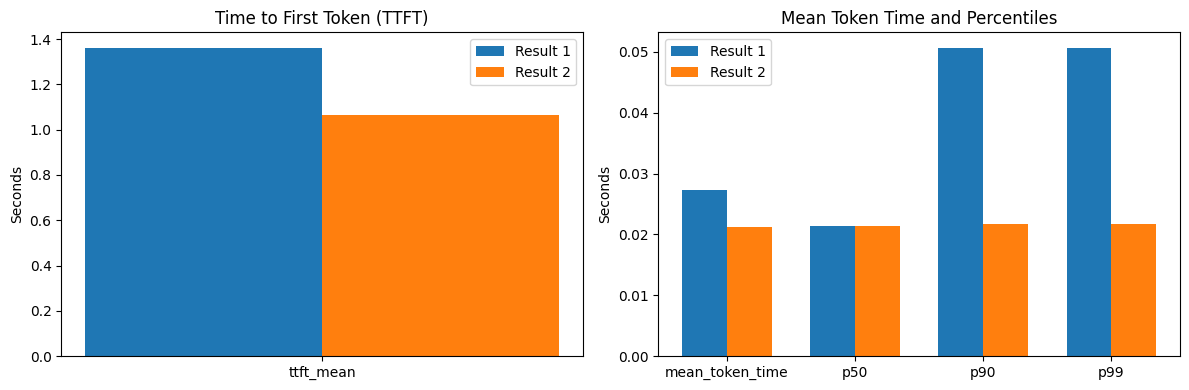

In [ ]:
plot_latency(results["latency_metrics"], results2["latency_metrics"])

This chart displays five latency metrics:

**mean_token_time**: the average time it takes to generate each token (in seconds).  
**ttft_mean**: Time To First Token, which measures the full initial overhead.  
**p50, p90, p99**: the 50th, 90th, and 99th percentiles of per-token time.

**P50 (50th percentile or median)**  
50% of token generation times are equal to or below this value. It's a robust measure of the “typical case” and less affected by extreme outliers than the mean.

**P90 (90th percentile)**  
Indicates that 90% of token times fall below this value. This starts to reflect the “bad case,” meaning those tokens that take longer than usual but are not extreme outliers.

**P99 (99th percentile)**  
Shows that 99% of token times are equal to or below this value. It represents the worst typical case—only 1% of tokens take longer. If your application is sensitive to occasional high latencies (e.g., real-time systems), this metric is critical.

### Throughhput vs Batch Size

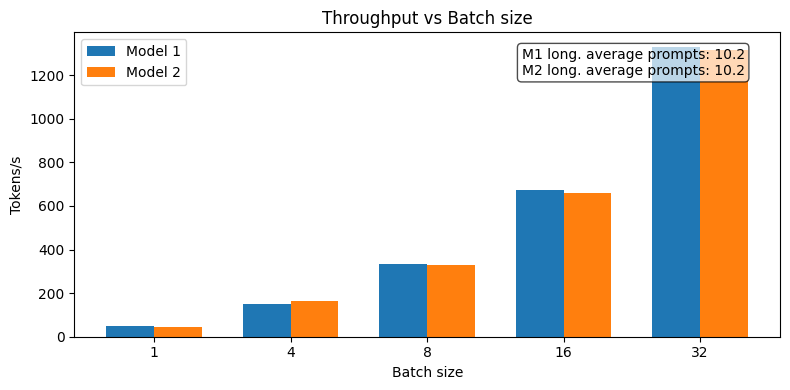

In [ ]:
plot_throughput(results, results2)

**Throughput vs Batch Size**  
This chart shows the number of tokens generated per second as a function of the batch size used during generation.

- At **batch=1**, all the overhead from invoking the model is applied to a single prompt, resulting in low throughput.  
- As batch size increases, the cost of kernel launches and data transfers is better amortized, so throughput grows almost linearly up to a saturation point.  
- With **batch=32**, the GPU is nearly fully utilized and reaches its maximum throughput. Beyond this point, memory limits or resource contention may prevent further gains.

This experiment helps identify the “sweet spot” for batch size, where tokens per second are maximized without exceeding the GPU’s capacity.

The chart clearly shows that performance (in tokens per second) increases as batch size grows:

* At batch=1, throughput is around 50 tokens/s.  
* At batch=4, it jumps to ≈170 tokens/s.  
* At batch=8, it reaches ≈330 tokens/s.  
* At batch=16, another jump to ≈660 tokens/s.  
* Finally, at batch=32, it peaks at ≈1,300 tokens/s.

In summary, each time the batch size doubles, throughput nearly doubles as well, showing an almost linear scale in this range. There are no visible inflection points—performance grows steadily up to 32 prompts per batch.

### Model Comparison  
The chart also shows that for small batch sizes, both models perform similarly, but as the batch size increases, the pruned model clearly outperforms the base model.

* At batch 16, it gains ≈120 additional tokens/s (~20% more).  
* At batch 32, the advantage increases to ≈125 tokens/s (~11% more).

This indicates that “Model 2” amortizes inference costs more efficiently at larger batch sizes.


### Plot Memory Scaling

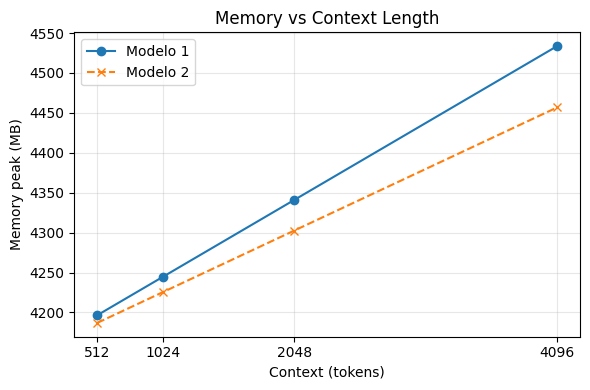

In [ ]:
plot_memory_scaling(results, results2)

This chart shows the GPU peak memory usage (in MB) measured during the generation of a single token, depending on the context length (number of prompt tokens) for two models:

* The X-axis marks different context lengths: 512, 1024, 2048, and 4096 tokens.  
* The Y-axis shows the maximum memory used in each case.

Each point reflects how much GPU memory is consumed when the model processes a prompt of that length.

#### Model Comparison  
As shown, the pruned model consistently consumes less GPU memory. The gap between the two models widens as the context window becomes larger.

### Environmental and energy consumption data

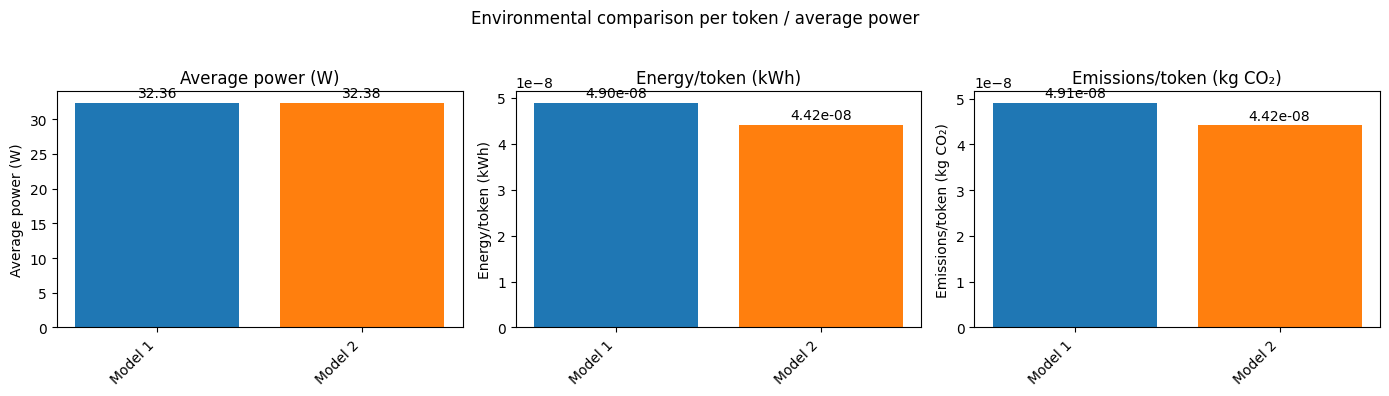

In [ ]:
plot_environmental_comparison(results, results2)

In this set of charts, you're looking at three different metrics that describe the energy and emissions impact of text generation:

**Average power (W)**  
Shows the average electrical power consumed by the GPU during the entire benchmarking process (i.e., how many watts it was drawing while generating tokens). It's a direct measure of the inference workload on the hardware.

**Energy per token (kWh/token)**  
Divides the total energy consumed (in kWh) by the number of tokens generated. It indicates how much energy is "spent" to produce a single token — the lower this value, the more energy-efficient the model is.

**Emissions per token (kg CO₂/token)**  
Converts the same per-token energy into estimated CO₂ emissions (in kilograms) using standard emission factors. This helps quantify the environmental cost of generating each token, making it easier to compare sustainability across models or configurations.

Together, these charts help you understand not just GPU speed or total consumption, but also the energy and ecological cost of each unit of text produced by the model.

# Conclusions
When developing optimized models using techniques like structured pruning, it's essential not only to evaluate performance in terms of accuracy or task-specific quality, but also to measure efficiency-related metrics such as latency, throughput, memory usage, and energy consumption.

These metrics help us:

* Quantify real-world inference speed improvements
* Detect resource savings in constrained environments (e.g., edge devices or cloud services)
* Evaluate the environmental impact of different architectures or optimization strategies
* Make informed decisions when choosing between multiple versions of a model

This notebook provides a structured and reproducible workflow to compare base models against their optimized counterparts.

*Note: All experiments have been run on Google Colab, using its default hardware configuration (typically a Tesla T4 GPU). Due to resource allocation and system load, results may vary slightly between runs. For consistent benchmarking, it's recommended to repeat the process several times or use a dedicated environment.*

# Authors Note.

In addition to creating content like this notebook and offering it under the MIT license, I have also contributed to repositories such as those of Hugging Face and Google Gemini.

I am especially proud of my book: [Rearchitecting LLMs - Structural techniques for efficient models](https://hubs.la/Q040tvsK0) (Manning Publications).

You can find it at Manning.

If you take a look and end up purchasing it, keep in mind that you can reach out with any questions via the Discussions section of this same repository or on any of my social media channels. I’ll do my best to respond as quickly as possible.

🚀 If you'd like to stay updated on my work, or even discuss some ideas, feel free to connect with me on [LinkedIn](https://www.linkedin.com/in/pere-martra/) or follow me on [X (Twitter)](https://x.com/PereMartra). I regularly share new tools, techniques, and insights on LLMs and AI optimization.🚀
